In [1]:
%load_ext autoreload
%autoreload

#!nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

import matplotlib.pyplot as plt

import json
import numpy

In [2]:
import LFPy
print(LFPy.__file__)

/gpfs/bbp.cscs.ch/home/damart/myenv/lib/python3.7/site-packages/LFPy/__init__.py


In [3]:
# Define electrode
import MEAutility as mu

sq_mea = mu.return_mea('SqMEA-10-15')
sq_mea.rotate([0, 1, 0], 90)
sq_mea.move([0, 0, -50])

electrode = LFPy.RecExtElectrode(probe=sq_mea)

In [4]:
import l5pc_model
import l5pc_evaluator

morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
param_configs = json.load(open('config/parameters.json'))
parameters = l5pc_model.define_parameters()
mechanisms = l5pc_model.define_mechanisms()

l5pc_cell = ephys.models.LFPyCellModel('l5pc', 
                                       v_init=-65., 
                                       morph=morphology, 
                                       mechs=mechanisms, 
                                       params=parameters)

param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      

fitness_protocols = l5pc_evaluator.define_protocols()
feature_configs = json.load(open('config/features.json'))
fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols)

#sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, electrode=electrode)
sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell)

evaluator = ephys.evaluators.CellEvaluator(                                          
                cell_model=l5pc_cell,                                                       
                param_names=param_names,                                                    
                fitness_protocols=fitness_protocols,                                        
                fitness_calculator=fitness_calculator,                                      
                sim=sim) 

In [5]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}

In [6]:
LFPy_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), 
                                         param_values=release_params)

In [7]:
#print(LFPy_responses['bAP.MEA.v']['voltage'].shape)
#plt.plot(LFPy_responses['bAP.MEA.v']['voltage'][0])

bAP.soma.v 2.688859238183583e-08
580.5284898056088 600.0
bAP.dend1.v 2.688859238183583e-08
580.5284898056088 600.0
bAP.dend2.v 2.688859238183583e-08
580.5284898056088 600.0
Step3.soma.v 80.98951934465624
2999.9999999999336 3000.0000000000337
Step2.soma.v 244.75477640972989
2999.9999999999336 3000.0000000000337
Step1.soma.v 47.54274917748044
2999.9999999999336 3000.0000000000337


/gpfs/bbp.cscs.ch/home/damart/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


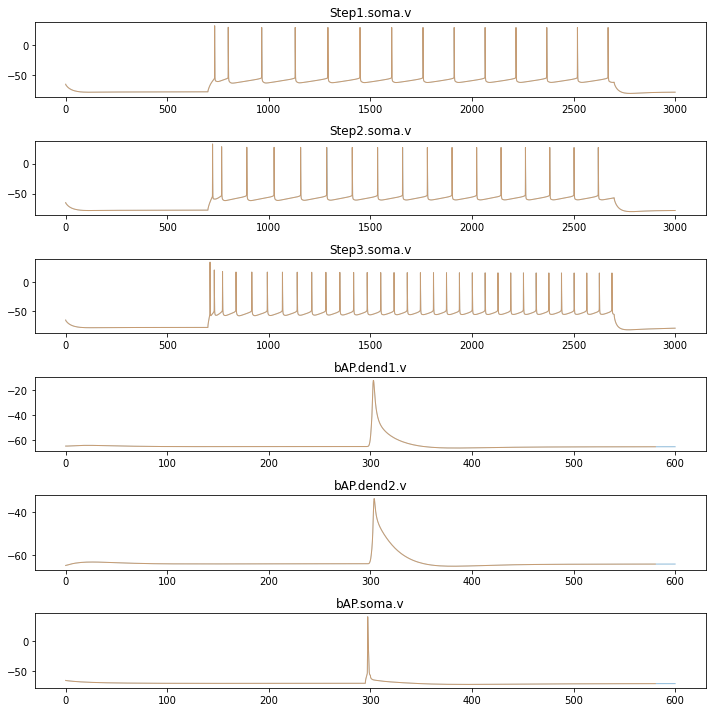

In [8]:
import pickle
original_responses = pickle.load(open("responses.pkl", "rb"))

fig, axes = plt.subplots(len(original_responses), figsize=(10,10))
for index, (resp_name, response) in enumerate(sorted(original_responses.items())):
    axes[index].plot(response['time'], response['voltage'], label=resp_name, lw=1.0, alpha=0.5)
    axes[index].plot(LFPy_responses[resp_name]['time'], LFPy_responses[resp_name]['voltage'], label=resp_name, lw=1.0, alpha=0.5)
    axes[index].set_title(resp_name)
fig.tight_layout()

for resp_name in original_responses:
    end = numpy.min([len(original_responses[resp_name]['time']), len(LFPy_responses[resp_name]['time'])])
    _ = numpy.sum(numpy.abs(original_responses[resp_name]['time'][:end]-LFPy_responses[resp_name]['time'][:end]))
    print(resp_name, _/end)
    print(LFPy_responses[resp_name]['time'].iloc[-1], original_responses[resp_name]['time'].iloc[-1])
fig.show()

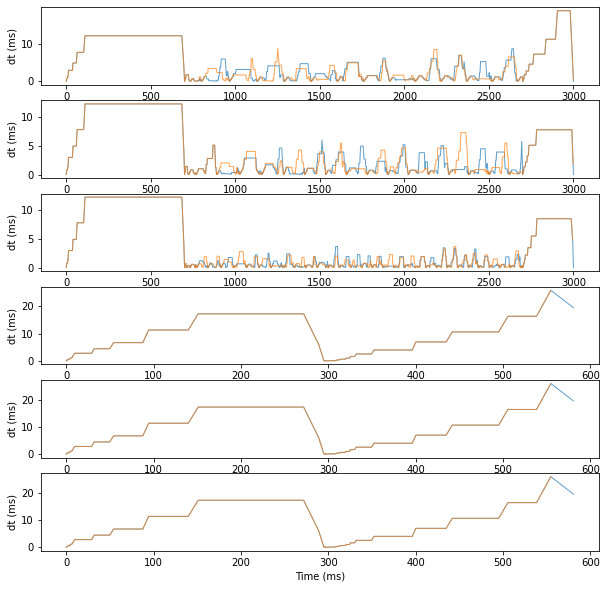

In [9]:
fig, axes = plt.subplots(len(original_responses), figsize=(10,10))
for index, (resp_name, response) in enumerate(sorted(original_responses.items())): 
        
        diff = numpy.diff(original_responses[resp_name]['time'])
        axes[index].plot(original_responses[resp_name]['time'][:-1], diff, lw=1.0, alpha=0.7)
        
        diff = numpy.diff(LFPy_responses[resp_name]['time'])
        axes[index].plot(LFPy_responses[resp_name]['time'][:-1], diff, lw=1.0, alpha=0.7)
        
        axes[index].set_xlabel("Time (ms)")
        axes[index].set_ylabel("dt (ms)")